In [36]:
## av_intel_scene_classification/solutions/rank_14

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
bs = 32

In [3]:
df = pd.read_csv('../train.csv')
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [7]:
tfms = get_transforms(do_flip=True)
data = (ImageList.from_csv('../images/', csv_name='../train.csv') #Where to find the data? -> in path and its subfolders
        .random_split_by_pct()              #How to split in train/valid? -> use the folders
        .label_from_df()            #How to label? -> depending on the folder of the filenames
        .add_test_folder(test_folder = '../test_data')              #Optionally add a test set (here default name is test)
        .transform(tfms, size=128)       #Data augmentation? -> use tfms with a size of 64
        .databunch())

/home/shashankwadhwa/env/lib/python3.6/site-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [9]:
print(data.classes)

[1, 2, 3, 4, 5]


In [10]:
learn = create_cnn(data, models.resnet152, metrics=[error_rate, accuracy], model_dir='.')

/home/shashankwadhwa/env/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/shashankwadhwa/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:04<00:00, 59908036.07it/s]


In [11]:
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.038261,0.698710,0.238400,0.761600,01:24
1,0.769035,0.486856,0.180000,0.820000,01:14
2,0.564846,0.407470,0.152000,0.848000,01:14
3,0.461498,0.342146,0.124000,0.876000,01:14
4,0.379968,0.327042,0.117600,0.882400,01:14
5,0.332639,0.315840,0.118400,0.881600,01:14
6,0.311588,0.307599,0.112000,0.888000,01:14


In [12]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

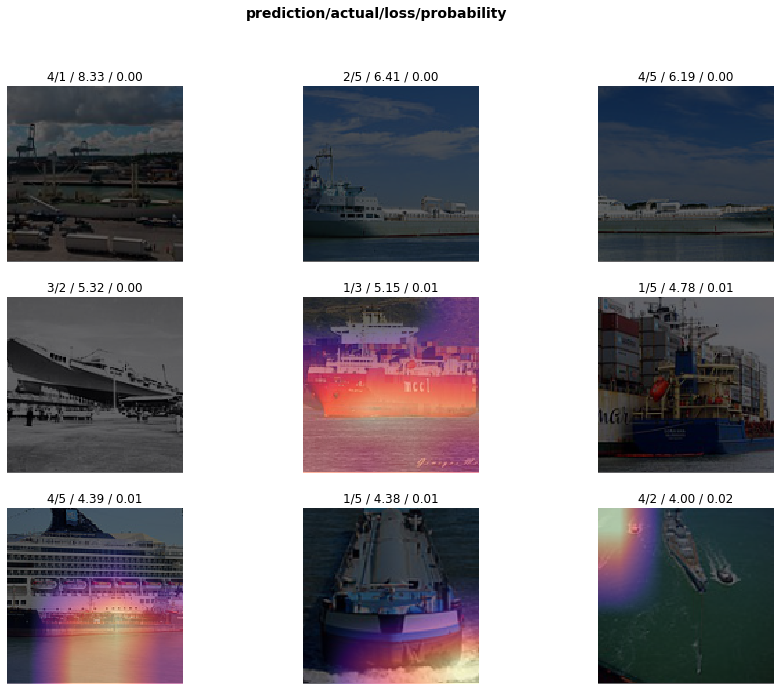

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

In [14]:
learn.save('k3_stage_1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


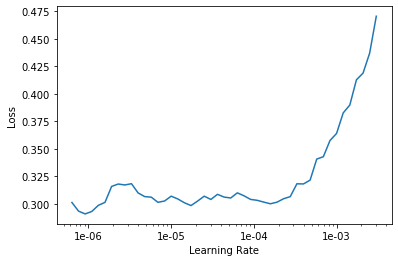

In [17]:
learn.recorder.plot()

In [18]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-6, 2e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.282095,0.306749,0.112800,0.887200,01:40
1,0.295137,0.300679,0.105600,0.894400,01:39
2,0.278454,0.296355,0.109600,0.890400,01:40
3,0.281768,0.291038,0.105600,0.894400,01:40
4,0.274363,0.286827,0.105600,0.894400,01:39
5,0.270090,0.287391,0.104800,0.895200,01:39
6,0.264232,0.285545,0.104800,0.895200,01:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


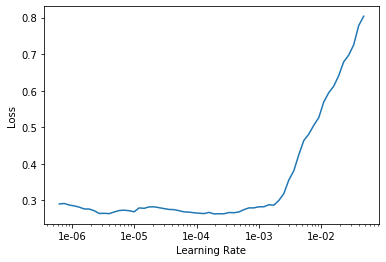

In [19]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


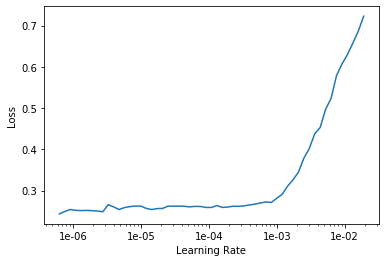

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 2.4e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.261732,0.285873,0.105600,0.894400,01:40
1,0.265154,0.281728,0.101600,0.898400,01:39
2,0.258265,0.278301,0.102400,0.897600,01:39
3,0.255721,0.277562,0.100800,0.899200,01:39


In [22]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(9e-7, 1e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.242589,0.274969,0.103200,0.896800,01:39
1,0.241755,0.272563,0.098400,0.901600,01:39
2,0.244591,0.271612,0.104000,0.896000,01:39


In [23]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(2e-6, 6e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.247672,0.261633,0.097600,0.902400,01:39
1,0.232300,0.251827,0.089600,0.910400,01:39
2,0.206987,0.239012,0.088000,0.912000,01:39
3,0.173844,0.233225,0.081600,0.918400,01:39
4,0.166918,0.230847,0.082400,0.917600,01:40


In [24]:
learn.save('k3_stage_2')

In [29]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

labelled_preds = []
for pred in preds:
    labelled_preds.append(int(np.argmax(pred)))

labelled_preds = [x+1 for x in labelled_preds]

In [30]:
pd.Series(labelled_preds).value_counts()

1    910
5    511
2    503
3    402
4    354
dtype: int64

In [31]:
from pathlib import Path
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [32]:
test_img_names[:5]

['2839642.jpg', '2149646.jpg', '1495100.jpg', '2831446.jpg', '2821176.jpg']

In [33]:
test_preds_tta = learn.TTA(ds_type=DatasetType.Test)
labelled_preds_tta = test_preds_tta[0].argmax(1).numpy()
labelled_preds_tta = [x+1 for x in labelled_preds_tta]

In [34]:
pd.Series(labelled_preds_tta).value_counts()

1    929
2    512
5    488
3    394
4    357
dtype: int64

In [35]:
test_pred_df = pd.DataFrame({'image': test_img_names})
test_pred_df['category'] = labelled_preds
test_pred_df.to_csv('k3_sub.csv', index=False)

test_pred_tta_df = pd.DataFrame({'image': test_img_names})
test_pred_tta_df['category'] = labelled_preds_tta
test_pred_tta_df.to_csv('k3_sub_tta.csv', index=False)